In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import re
import random as rd
from scipy.optimize import curve_fit
os.chdir('K:/who/corona/data')

In [2]:
global rainbow

In [3]:
rainbow=['#ff0000',
 '#ff0500',
 '#ff0a00',
 '#ff0f00',
 '#ff1400',
 '#ff1800',
 '#ff1d00',
 '#ff2200',
 '#ff2700',
 '#ff2c00',
 '#ff3100',
 '#ff3600',
 '#ff3b00',
 '#ff4000',
 '#ff4400',
 '#ff4900',
 '#ff4e00',
 '#ff5300',
 '#ff5800',
 '#ff5d00',
 '#ff6200',
 '#ff6700',
 '#ff6b00',
 '#ff7000',
 '#ff7500',
 '#ff7a00',
 '#ff7f00',
 '#ff8400',
 '#ff8900',
 '#ff8e00',
 '#ff9300',
 '#ff9800',
 '#ff9d00',
 '#ffa100',
 '#ffa600',
 '#ffab00',
 '#ffb000',
 '#ffb500',
 '#ffba00',
 '#ffbf00',
 '#ffc400',
 '#ffc900',
 '#ffce00',
 '#ffd300',
 '#ffd800',
 '#ffdd00',
 '#ffe100',
 '#ffe600',
 '#ffeb00',
 '#fff000',
 '#fff500',
 '#fffa00',
 '#ffff00',
 '#f5ff00',
 '#ebff00',
 '#e2ff00',
 '#d8ff00',
 '#ceff00',
 '#c4ff00',
 '#baff00',
 '#b1ff00',
 '#a7ff00',
 '#9dff00',
 '#93ff00',
 '#89ff00',
 '#7fff00',
 '#76ff00',
 '#6cff00',
 '#62ff00',
 '#58ff00',
 '#4eff00',
 '#45ff00',
 '#3bff00',
 '#31ff00',
 '#27ff00',
 '#1dff00',
 '#14ff00',
 '#0aff00',
 '#00ff00',
 '#00ff0a',
 '#00ff14',
 '#00ff1d',
 '#00ff27',
 '#00ff31',
 '#00ff3b',
 '#00ff45',
 '#00ff4e',
 '#00ff58',
 '#00ff62',
 '#00ff6c',
 '#00ff76',
 '#00ff80',
 '#00ff89',
 '#00ff93',
 '#00ff9d',
 '#00ffa7',
 '#00ffb1',
 '#00ffba',
 '#00ffc4',
 '#00ffce',
 '#00ffd8',
 '#00ffe2',
 '#00ffeb',
 '#00fff5',
 '#00ffff',
 '#00f5ff',
 '#00ebff',
 '#00e2ff',
 '#00d8ff',
 '#00ceff',
 '#00c4ff',
 '#00baff',
 '#00b1ff',
 '#00a7ff',
 '#009dff',
 '#0093ff',
 '#0089ff',
 '#007fff',
 '#0076ff',
 '#006cff',
 '#0062ff',
 '#0058ff',
 '#004eff',
 '#0045ff',
 '#003bff',
 '#0031ff',
 '#0027ff',
 '#001dff',
 '#0014ff',
 '#000aff',
 '#0000ff',
 '#0500ff',
 '#0b00ff',
 '#1000ff',
 '#1500ff',
 '#1b00ff',
 '#2000ff',
 '#2500ff',
 '#2b00ff',
 '#3000ff',
 '#3500ff',
 '#3b00ff',
 '#4000ff',
 '#4500ff',
 '#4b00ff',
 '#5000ff',
 '#5600ff',
 '#5b00ff',
 '#6000ff',
 '#6600ff',
 '#6b00ff',
 '#7000ff',
 '#7600ff',
 '#7b00ff',
 '#8000ff',
 '#8600ff',
 '#8b00ff']

In [4]:
def gompertz(t,a,b,c):
    return a*np.exp(-1*b*np.exp(-1*c*t))

def get_gompertz_params(x,y):
    popt,pcov=curve_fit(gompertz,x,y,p0=(max(y),1,1))
    return popt

In [5]:
def gompertz_forecast(df,col,country,save=False):
    
    data=df[[col,'report date']][df['Country/Territory/Area']==country].dropna()

    data.set_index('report date',inplace=True
                   )

    data.index=pd.to_datetime(data.index)
    
    #get actual time difference as the publish frequency isnt consistent
    dif=pd.Series(data.index).diff()

    data['time']=dif.fillna('0').apply(lambda x: re.findall('\d+',str(x))[0]).astype(int).cumsum().tolist()
    
    #using mle to estimate gompertz model
    try:
        a,b,c=get_gompertz_params(data['time'],data[col])
    except RuntimeError:
        return

    #start from 3 months ago to a year later
    infected=[gompertz(t,a,b,c) for t in range(-100,400)]
    
    #get the estimated minimum point where the first case happens
    est_min=infected.index([i for i in infected if i>0.8][0])-100
    est_min_p=int(round(infected[est_min+100],0))
    
    #the actual minimum point may not be the first case
    act_min=data['time'][data[col]>0].iloc[0]
    act_min_p=int(data[col][data[col]>0].iloc[0])
    
    #95% maximum point, not 95% percentile
    #we assume this is where we exit exponential growth
    max95=infected.index([i for i in infected if i>max(infected)*0.95][0])-100
    max95_p=int(round(infected[max95+100],0))
    
    #viz
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.plot(range(-100,400),infected,alpha=0.5,lw=3,label='estimated',c='#282726')
    plt.plot(data['time'],data[col],alpha=0.5,lw=7,label='actual',c=rd.choice(rainbow))
    plt.legend(loc=4)
    plt.title(f'{country}')
    plt.xlabel(f"Time\nwhere t0 is {str(data.index[0])[:10]}")
    plt.ylabel(col)

    
    plt.text(100,max(infected)*0.5,
             f'estimated minimum point ({est_min_p}) reached: t'+f'+{est_min}' if est_min>0 else f'estimated minimum point ({est_min_p}) reached: t'+f'{est_min}')
    plt.text(100,max(infected)*0.4,
             f'actual minimum point ({act_min_p}) reached: t'+f'+{act_min}' if act_min!=0 else f'actual minimum point ({act_min_p}) reached: t0')
    plt.text(100,max(infected)*0.3,
             f'estimated 95% maximum point ({max95_p}) reached: t'+f'+{max95}')
    
    
    if save:
        plt.savefig(f'gompertz-corona-{country.lower()}-{col.lower()}.png')
        
    plt.show()
    

In [6]:
df=pd.read_csv('grand.csv')

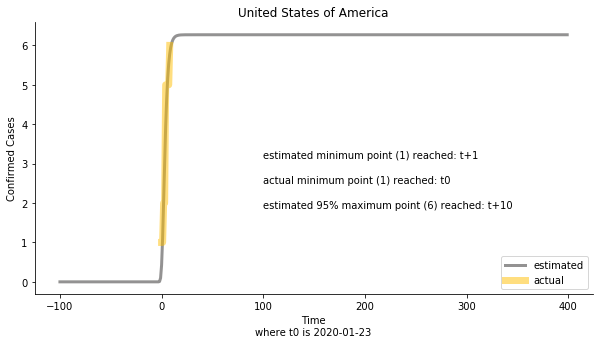

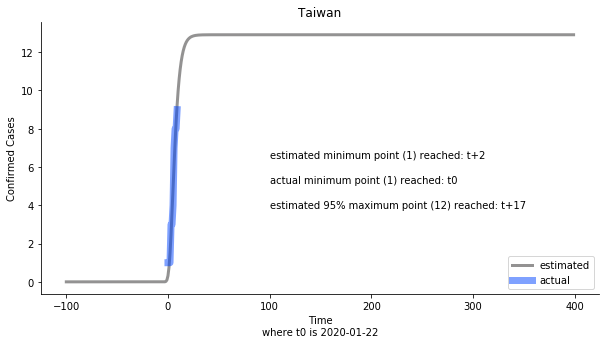

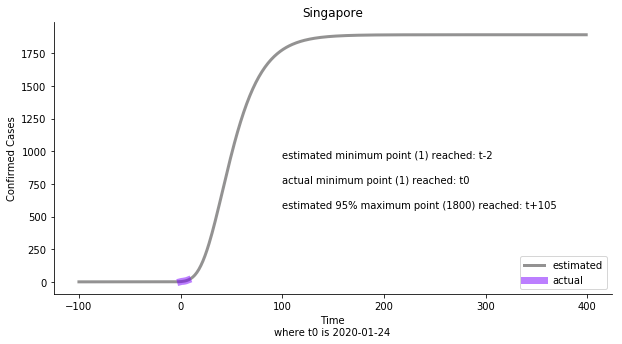

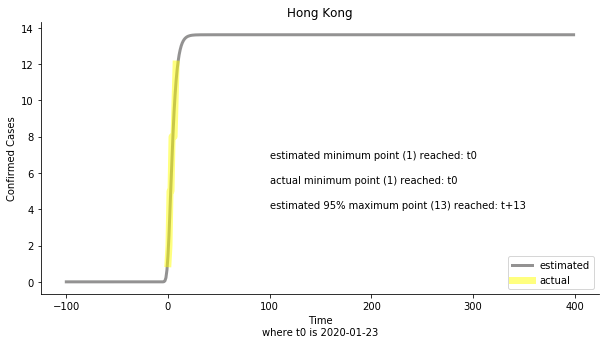

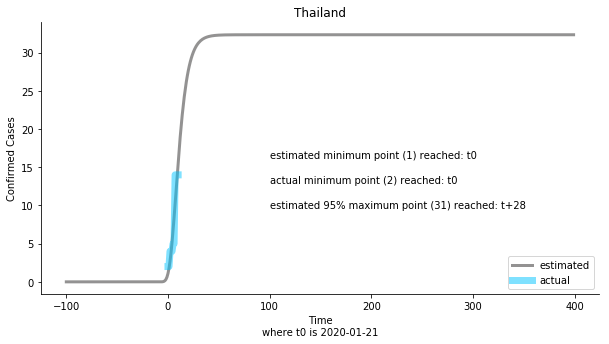

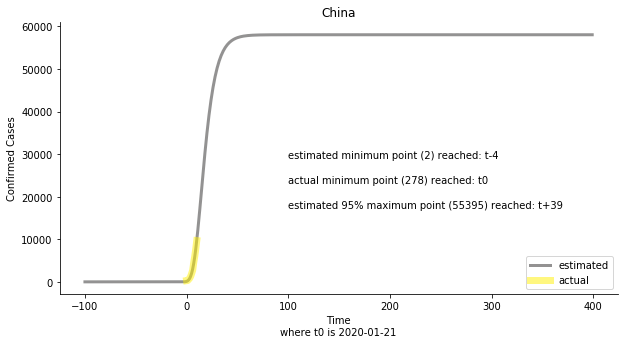

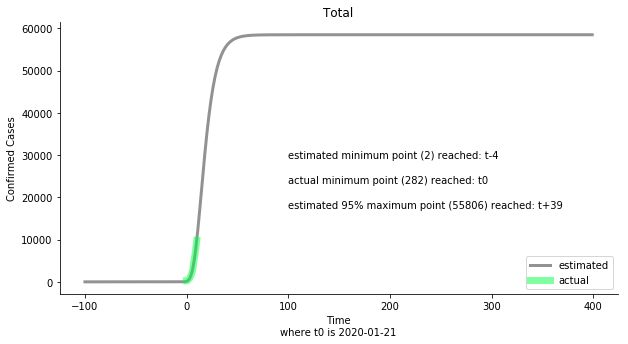

In [7]:
#using random color from rainbow color set
#graphique looks like LED light on an electric wire
for i in ['United States of America','Taiwan', 
          'Singapore', 'Hong Kong','Thailand', 'China', 'Total']:
    
    gompertz_forecast(df,'Confirmed Cases',i)

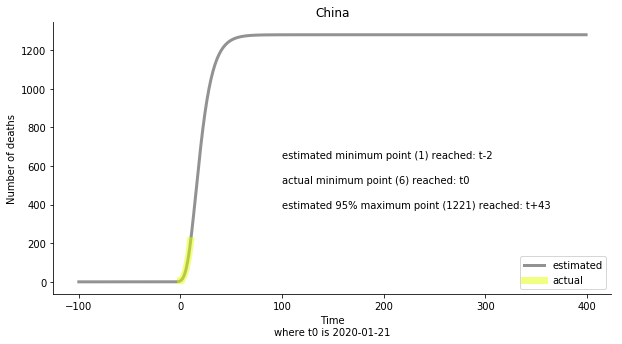

In [8]:
gompertz_forecast(df,'Number of deaths','China')